In [257]:
# import pip
# pip.main(["install", "category_encoders"])

In [258]:
import warnings
warnings.filterwarnings('ignore')

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [260]:
train = pd.read_csv('train.csv',index_col=0)

In [261]:
train.shape

(891, 11)

In [262]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [263]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

Replace all null values with the Letter N

In [264]:
train["Cabin"].fillna("N",inplace=True)

Extract the first letter in the Cabin column

In [265]:
train["Cabin"] = train["Cabin"].apply(lambda x:x[0])

In [266]:
train[train["Age"].isnull()].to_csv("age_null.csv")

Identifying Children and Mothers

In [267]:
def child(name,parch):
    if "Master" in name:
        return 1
    elif "Miss" in name:
        if parch > 0:
            return 1
        else:
            return 0
    else:
        return 0

def mother(name,parch):
    if "Mrs" in name:
        if parch > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [268]:
train["Child"] = train.apply(lambda x: child(x["Name"],x["Parch"]),axis=1)

In [269]:
train["Mother"] = train.apply(lambda x: mother(x["Name"],x["Parch"]),axis=1)

Age Classification

- Child (0-17 years)
- Young Adult (18-39 years)
- Middle Aged Adult (40-59)
- Senior Adult (60 years and above)

In [270]:
def age_group(x,child,mother):
    if x <= 17:
        return "Child"
    elif x >=18 and x <= 39:
        return "Young Adult"
    elif x >=40 and x <= 59:
        return "Middle Aged"
    elif x >= 60:
        return "Senior"
    else:
        if child == 1:
            return "Child"
        if mother == 1:
            return "Young Adult"
        return "Young Adult"

In [271]:
train["Age_Group"] = train.apply(lambda x: age_group(x["Age"],x["Child"],x["Mother"]),axis=1)

Identify Last Name

In [272]:
train["Lastname"] = train.apply(lambda x: x["Name"].split(',')[0],axis=1)

Calculate Fare per Passenger

In [273]:
def calculate_fare(fare,sibsp,parch):
    if fare > 8:
        newfare = round(fare/(sibsp+parch+1))
        if newfare > 7:
            return newfare
        else:
            return 7
    else:
        return round(fare)

In [274]:
train["Fare_per_Passenger"] = train.apply(lambda x: calculate_fare(x["Fare"],x["SibSp"],x["Parch"]),axis=1)

In [275]:
train[['Pclass','SibSp','Parch','Ticket','Fare','Fare_per_Passenger']].to_csv("fare.csv")

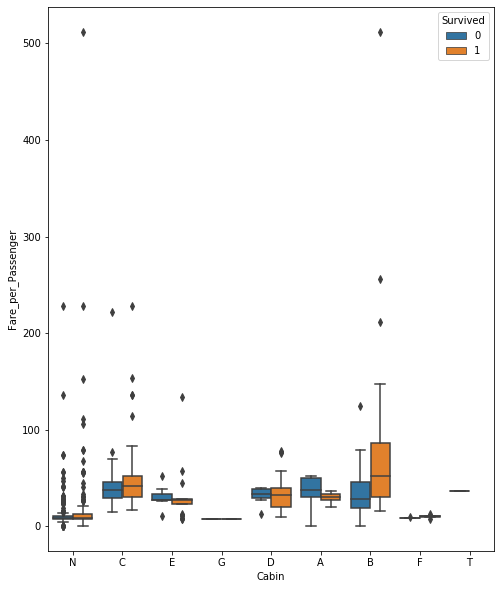

In [276]:
sns.boxplot(x="Cabin",y='Fare_per_Passenger',hue="Survived",data=train)

Drop Unwanted Columns

In [277]:
train.drop(["Name","Ticket",'Fare','Age','Lastname','Child'],axis=1,inplace=True)

In [278]:
train["Embarked"].dropna(inplace=True)

## Data Encoding

In [279]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Mother,Age_Group,Fare_per_Passenger
PassengerId,,,,,,,,,,
1,0,3,male,1,0,N,S,0,Young Adult,7
2,1,1,female,1,0,C,C,0,Young Adult,36
3,1,3,female,0,0,N,S,0,Young Adult,8
4,1,1,female,1,0,C,S,0,Young Adult,27
5,0,3,male,0,0,N,S,0,Young Adult,8


In [280]:
train = pd.get_dummies(train,columns=['Sex','Cabin','Embarked','Age_Group'])

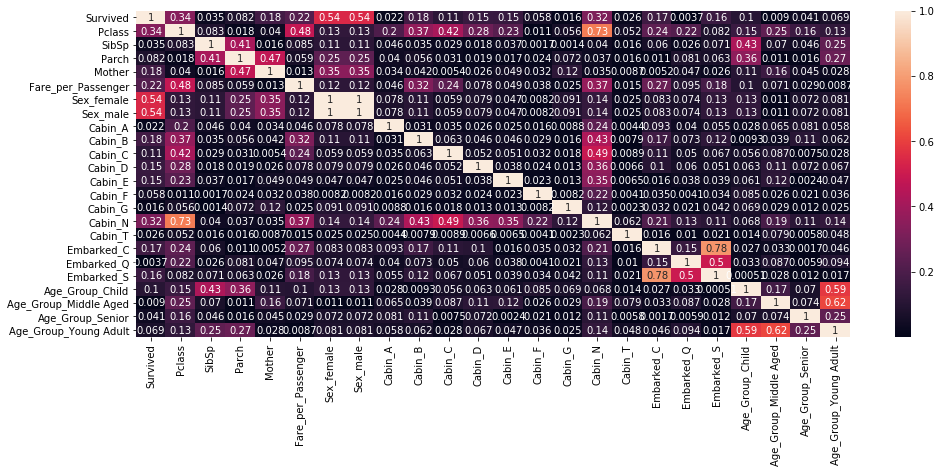

In [281]:
plt.figure(figsize=(16,6))
corr = train.corr().abs()
sns.heatmap(corr,annot=True)

## Feature Selection

In [282]:
cor_target = abs(corr["Survived"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

Survived              1.000000
Pclass                0.338481
Mother                0.175967
Fare_per_Passenger    0.221686
Sex_female            0.543351
Sex_male              0.543351
Cabin_B               0.175095
Cabin_C               0.114652
Cabin_D               0.150716
Cabin_E               0.145321
Cabin_N               0.316912
Embarked_C            0.168240
Embarked_S            0.155660
Age_Group_Child       0.103561
Name: Survived, dtype: float64

In [283]:
train[list(relevant_features[1:].index)].corr().abs()

,Pclass,Mother,Fare_per_Passenger,Sex_female,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_N,Embarked_C,Embarked_S,Age_Group_Child
Pclass,1.000000,0.040312,0.480812,0.131900,0.131900,0.369572,0.417048,0.278690,0.230091,0.725541,0.243292,0.081720,0.154614
Mother,0.040312,1.000000,0.012860,0.351054,0.351054,0.042328,0.005427,0.026301,0.049426,0.034983,0.005215,0.026077,0.105101
Fare_per_Passenger,0.480812,0.012860,1.000000,0.118075,0.118075,0.324504,0.239482,0.078182,0.048976,0.371698,0.270263,0.184741,0.099537
Sex_female,0.131900,0.351054,0.118075,1.000000,1.000000,0.109689,0.058649,0.079248,0.047003,0.140391,0.082853,0.125722,0.132122
Sex_male,0.131900,0.351054,0.118075,1.000000,1.000000,0.109689,0.058649,0.079248,0.047003,0.140391,0.082853,0.125722,0.132122
Cabin_B,0.369572,0.042328,0.324504,0.109689,0.109689,1.000000,0.062841,0.046280,0.045547,0.433053,0.168642,0.123057,0.009315
Cabin_C,0.417048,0.005427,0.239482,0.058649,0.058649,0.062841,1.000000,0.052225,0.051398,0.488683,0.113952,0.066995,0.056261
Cabin_D,0.278690,0.026301,0.078182,0.079248,0.079248,0.046280,0.052225,1.000000,0.037852,0.359896,0.102977,0.051139,0.062536
Cabin_E,0.230091,0.049426,0.048976,0.047003,0.047003,0.045547,0.051398,0.037852,1.000000,0.354194,0.015939,0.038685,0.061021
Cabin_N,0.725541,0.034983,0.371698,0.140391,0.140391,0.433053,0.488683,0.359896,0.354194,1.000000,0.208528,0.110087,0.067832


In [284]:
cols = list(train.columns)

In [318]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = train[cols[1:]]
y = train[['Survived']]

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model,8)
fit = rfe.fit(X, y)
print(f"Num Features: {fit.n_features_}")
print(f"Feature Ranking: {fit.ranking_}")

Num Features: 8
Feature Ranking: [ 1  4 10  9 16  1  1 11 12  7  1  1  1  5  6  8 13 14  3  2  1  1 15]


In [319]:
ranking = pd.Series(fit.ranking_,index=list(X.columns))
ranking

selected_cols = ranking[ranking==True].index
print(selected_cols)

Index(['Pclass', 'Sex_female', 'Sex_male', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Age_Group_Middle Aged', 'Age_Group_Senior'],
      dtype='object')


In [320]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.003848
Best score using built-in LassoCV: 0.398149


In [321]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 11 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

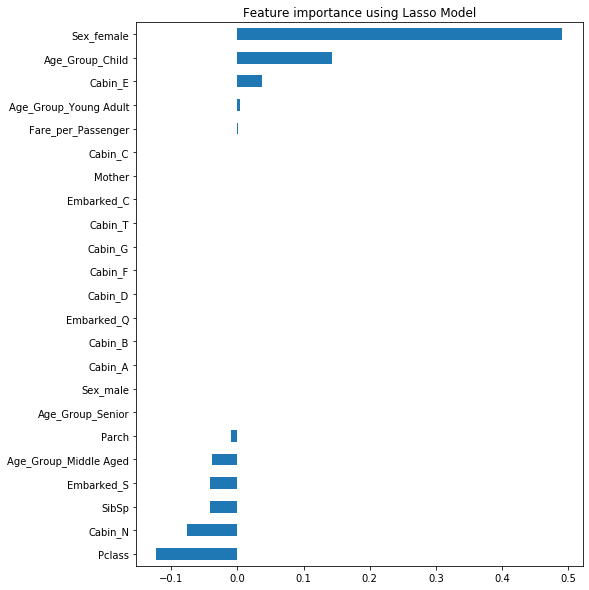

In [322]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [395]:
selected_cols

Index(['Pclass', 'Sex_female', 'Sex_male', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Age_Group_Middle Aged', 'Age_Group_Senior'],
      dtype='object')

In [429]:
selected_cols = ['Pclass', 'Sex_female', 'SibSp','Embarked_S', 
                 'Cabin_E', 'Cabin_N','Parch','Fare_per_Passenger',
       'Age_Group_Middle Aged', 'Age_Group_Senior','Age_Group_Child','Age_Group_Young Adult']

In [485]:
X = train[selected_cols]

y = train[['Survived']]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=100)

In [486]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Logistic Regression

In [487]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [488]:
y_predict = model.predict(X_test)

In [489]:
model.score(X_test,y_test)

0.7892376681614349

In [490]:
from sklearn.metrics import confusion_matrix
tn_fp,fn_tp = confusion_matrix(y_test, y_predict)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 110
False Positive: 17
False Negative: 30
True Positive: 66


In [491]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.87      0.82       127
           1       0.80      0.69      0.74        96

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



### Naive Bayes

In [492]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,y_train)
nb.score(X_test,y_test)

0.7130044843049327

### K-Nearest Neighbors

In [493]:
import math
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

y_pred_knn = knn.predict(X_test)
accuracy_score(y_test, y_pred_knn)

5


0.8116591928251121

In [494]:
tn_fp,fn_tp = confusion_matrix(y_test, y_pred_knn)
classification_report(y_test, y_pred_knn)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 114
False Positive: 13
False Negative: 29
True Positive: 67


## Ensemble Methods

In [495]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

### Decision Tree

In [496]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_features=10,max_depth=10)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.7847533632286996

In [497]:
tn_fp,fn_tp = confusion_matrix(y_test, y_pred_dt)
classification_report(y_test, y_pred_dt)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 117
False Positive: 10
False Negative: 38
True Positive: 58


In [498]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       127
           1       0.85      0.60      0.71        96

    accuracy                           0.78       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.80      0.78      0.78       223



### Random Forest

In [499]:
rf = RandomForestClassifier(n_estimators=10,random_state=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.7937219730941704

In [500]:
tn_fp,fn_tp = confusion_matrix(y_test, y_pred_rf)
classification_report(y_test, y_pred_rf)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 114
False Positive: 13
False Negative: 33
True Positive: 63


In [501]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       127
           1       0.83      0.66      0.73        96

    accuracy                           0.79       223
   macro avg       0.80      0.78      0.78       223
weighted avg       0.80      0.79      0.79       223



### Ada Boosting

In [502]:
ab = AdaBoostClassifier(n_estimators=10, random_state=100)
ab.fit(X_train, y_train)
y_pred_ab = ab.predict(X_test)
accuracy_score(y_test, y_pred_ab)

0.7847533632286996

In [503]:
tn_fp,fn_tp = confusion_matrix(y_test, y_pred_ab)
classification_report(y_test, y_pred_ab)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 111
False Positive: 16
False Negative: 32
True Positive: 64


In [504]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       127
           1       0.80      0.67      0.73        96

    accuracy                           0.78       223
   macro avg       0.79      0.77      0.77       223
weighted avg       0.79      0.78      0.78       223



### Gradient Boosting

In [505]:
gb = GradientBoostingClassifier(n_estimators=10,random_state=100)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
accuracy_score(y_test, y_pred_gb)

0.7757847533632287

In [506]:
tn_fp,fn_tp = confusion_matrix(y_test, y_pred_gb)
classification_report(y_test, y_pred_gb)

print(f"True Negative: {tn_fp[0]:,}")
print(f"False Positive: {tn_fp[1]:,}")
print(f"False Negative: {fn_tp[0]:,}")
print(f"True Positive: {fn_tp[1]:,}")

True Negative: 120
False Positive: 7
False Negative: 43
True Positive: 53


In [507]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       127
           1       0.88      0.55      0.68        96

    accuracy                           0.78       223
   macro avg       0.81      0.75      0.75       223
weighted avg       0.80      0.78      0.76       223



In [508]:
test = pd.read_csv('test.csv',index_col=0)

In [509]:
test["Cabin"].fillna("N",inplace=True)
test["Cabin"] = test["Cabin"].apply(lambda x:x[0])
test["Child"] = test.apply(lambda x: child(x["Name"],x["Parch"]),axis=1)
test["Mother"] = test.apply(lambda x: mother(x["Name"],x["Parch"]),axis=1)
test["Fare"].fillna(0,inplace=True)

test["Age_Group"] = test.apply(lambda x: age_group(x["Age"],x["Child"],x["Mother"]),axis=1)
test["Lastname"] = test.apply(lambda x: x["Name"].split(',')[0],axis=1)
test["Fare_per_Passenger"] = test.apply(lambda x: calculate_fare(x["Fare"],x["SibSp"],x["Parch"]),axis=1)
test.drop(["Name","Ticket",'Fare','Age','Lastname','Child'],axis=1,inplace=True)
test = pd.get_dummies(test,columns=['Sex','Cabin','Embarked','Age_Group'])

In [510]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Pclass                 418 non-null    int64
 1   SibSp                  418 non-null    int64
 2   Parch                  418 non-null    int64
 3   Mother                 418 non-null    int64
 4   Fare_per_Passenger     418 non-null    int64
 5   Sex_female             418 non-null    uint8
 6   Sex_male               418 non-null    uint8
 7   Cabin_A                418 non-null    uint8
 8   Cabin_B                418 non-null    uint8
 9   Cabin_C                418 non-null    uint8
 10  Cabin_D                418 non-null    uint8
 11  Cabin_E                418 non-null    uint8
 12  Cabin_F                418 non-null    uint8
 13  Cabin_G                418 non-null    uint8
 14  Cabin_N                418 non-null    uint8
 15  Embarked_C             418 non-null  

In [511]:
test = test[selected_cols]

In [512]:
Survived = model.predict(test)

In [513]:
newtest=test[:]

In [514]:
newtest.insert(0,"Survived",Survived)

In [515]:
newtest[["Survived"]].to_csv("submission_gb_2.csv")